# Split the Rydberg Hamiltonian into chunks of blocks

In [1]:
from pathlib import Path

In [2]:
import qutip
import numpy as np
import matplotlib.pylab as plt
import scipy.sparse

In [3]:
from src.qdyn.io import read_indexed_matrix
from src.qdyn.model import LevelModel
from src.qdyn.pulse import Pulse
from src.plots import show_spy, plot_population
from src.blocksplitting import split_AB, split_AB_blocks
from src.ham import rydberg_hamiltonian

In [4]:
%matplotlib notebook

In [5]:
V_per_cm = 1.0 / 5.14220624463189208e09

In [6]:
# 1-based indices of the initial and target states
N_INITIAL = 1423
N_TARGET = 2696
# size of Hilbert space
N_HILBERT = N_TARGET

In [7]:
H = rydberg_hamiltonian(
    N_HILBERT,
    'data/ham_drift.dat',
    'data/ham_sig.dat',
    'data/ham_pi.dat',
    F_DC=2.5 * V_per_cm,
    Omega_sigma=Pulse.read('./data/pulse_sig.dat')
)

In [8]:
psi0 = qutip.ket([N_INITIAL-1], dim=H[0].shape[0])
psi_target = qutip.ket([N_TARGET-1], dim=H[0].shape[0])

In [9]:
Amatrix, Bmatrix = split_AB(
    H[1][0].data,
    block_info=np.genfromtxt("./data/n_states_red_block.dat", dtype=np.int32),
    n=N_HILBERT,
    as_qobj=True,
)

In [10]:
assert ((Amatrix + Bmatrix) - H[1][0]).data.nnz == 0

In [11]:
A, B = split_AB_blocks(
    H[1][0].data,
    block_info=np.genfromtxt("./data/n_states_red_block.dat", dtype=np.int32),
    n=N_HILBERT,
    as_qobj=True,
)

In [12]:
assert (sum(A) - Amatrix).data.nnz == 0

In [13]:
assert (sum(B) - Bmatrix).data.nnz == 0

In [14]:
assert ((sum(A) + sum(B)) - H[1][0]).data.nnz == 0

<IPython.core.display.Javascript object>


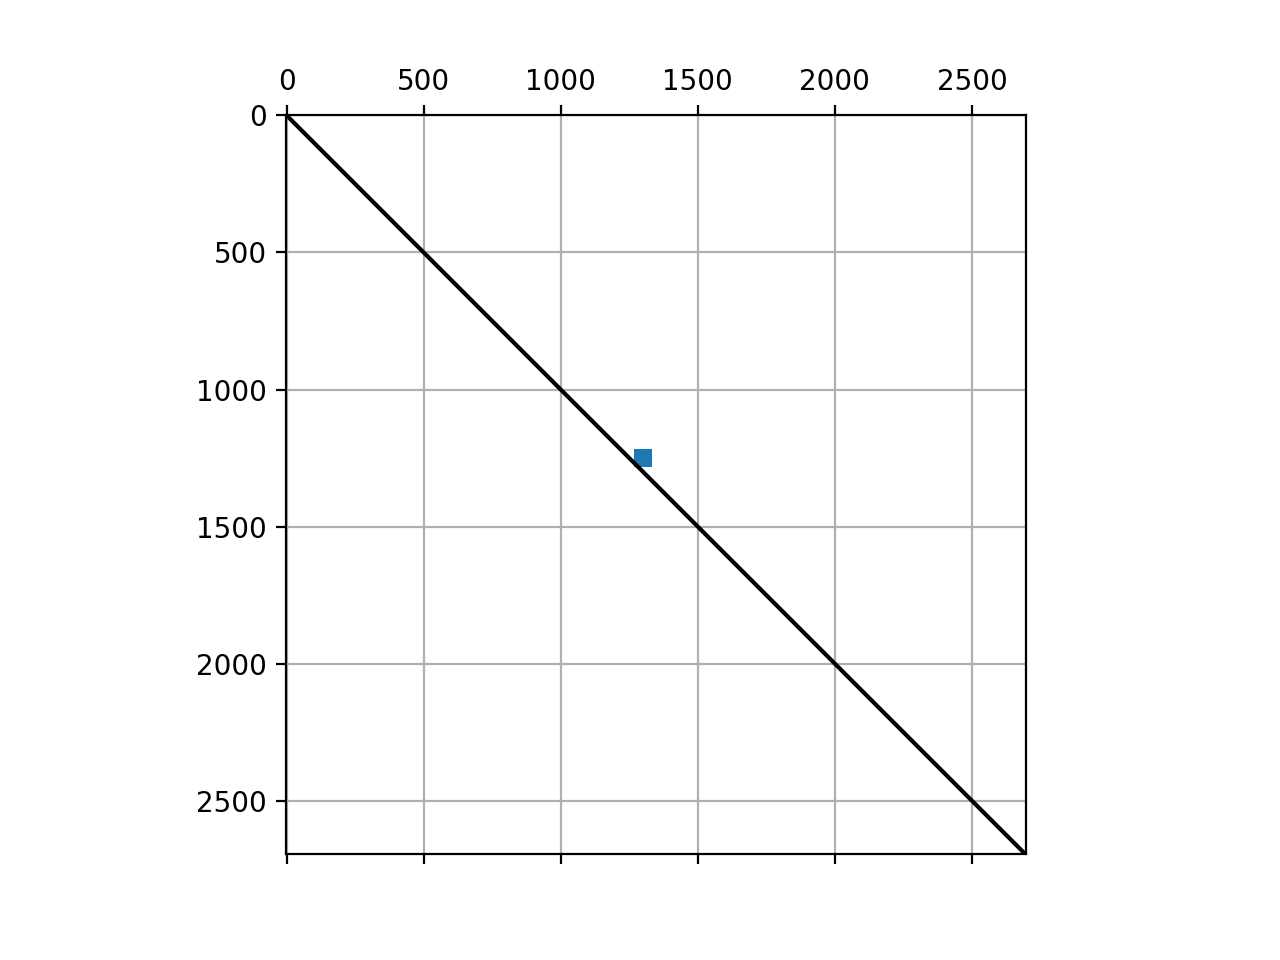

In [15]:
show_spy(A[24], show_diagonal=True, grid=True)

<IPython.core.display.Javascript object>


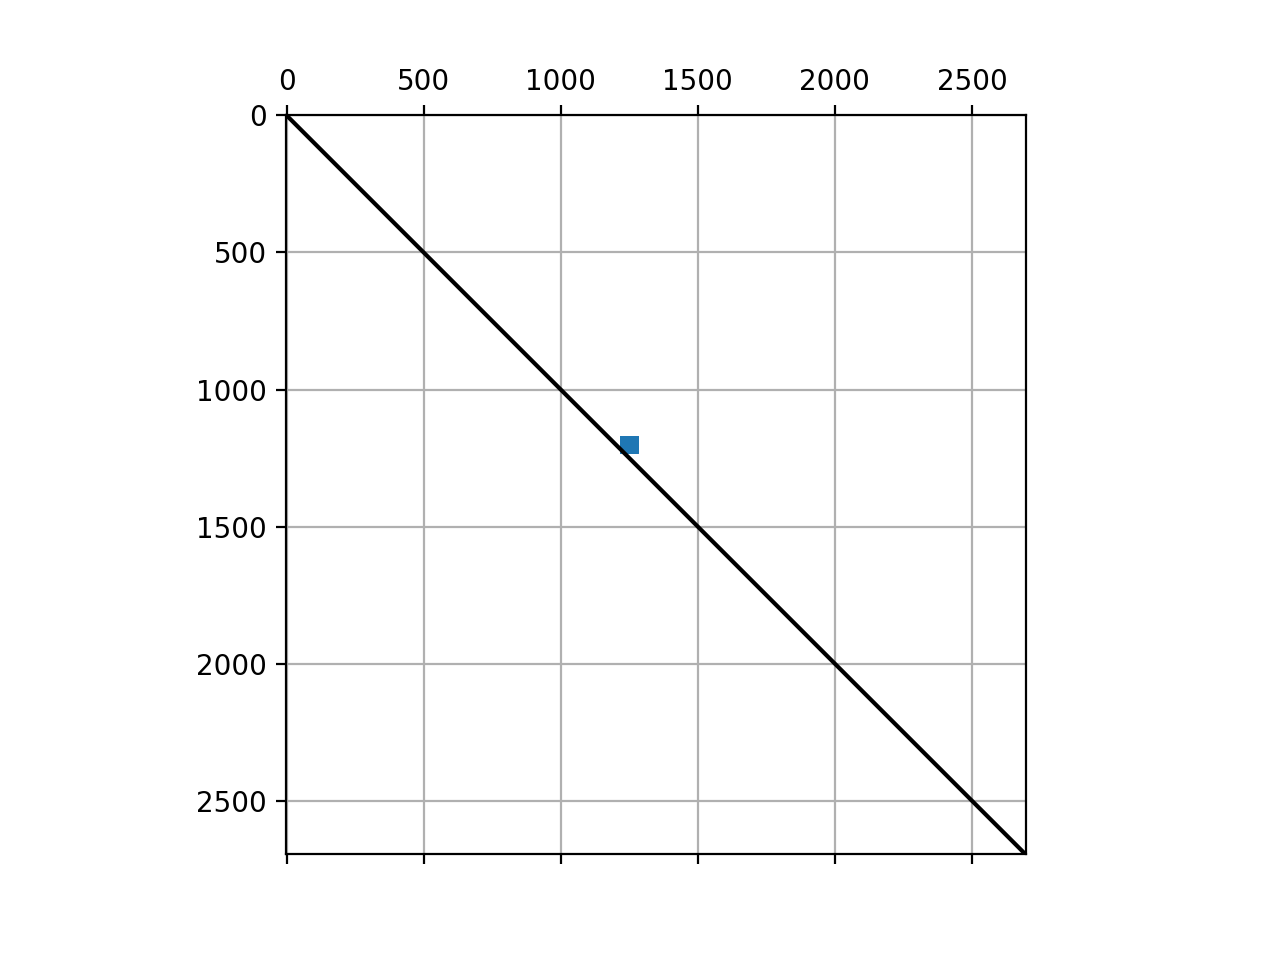

In [16]:
show_spy(B[24], show_diagonal=True, grid=True)

<IPython.core.display.Javascript object>


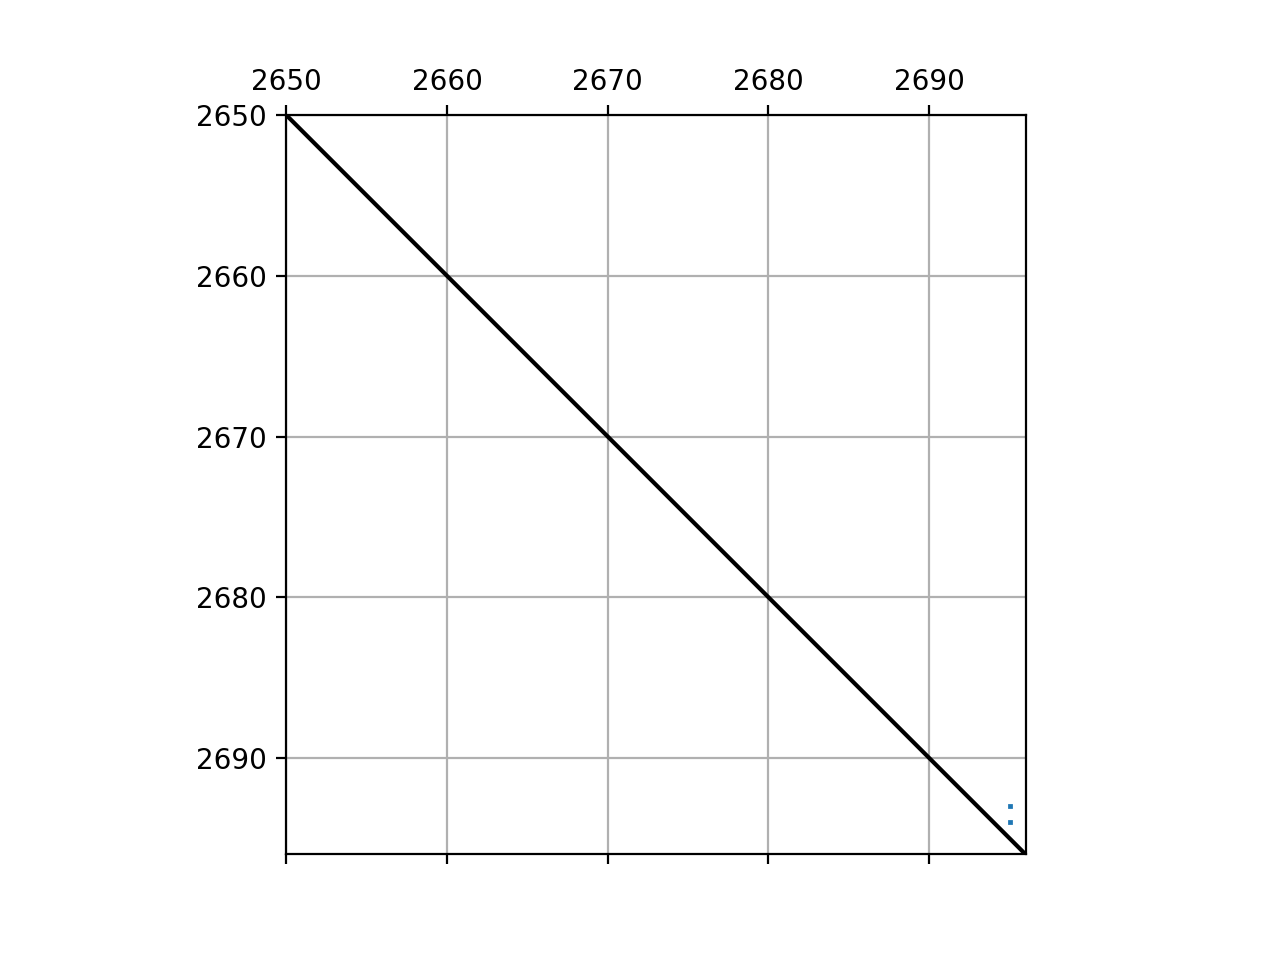

In [17]:
show_spy(A[-1], show_diagonal=True, grid=True, xlim=(2650, N_TARGET), ylim=(N_TARGET, 2650))

<IPython.core.display.Javascript object>


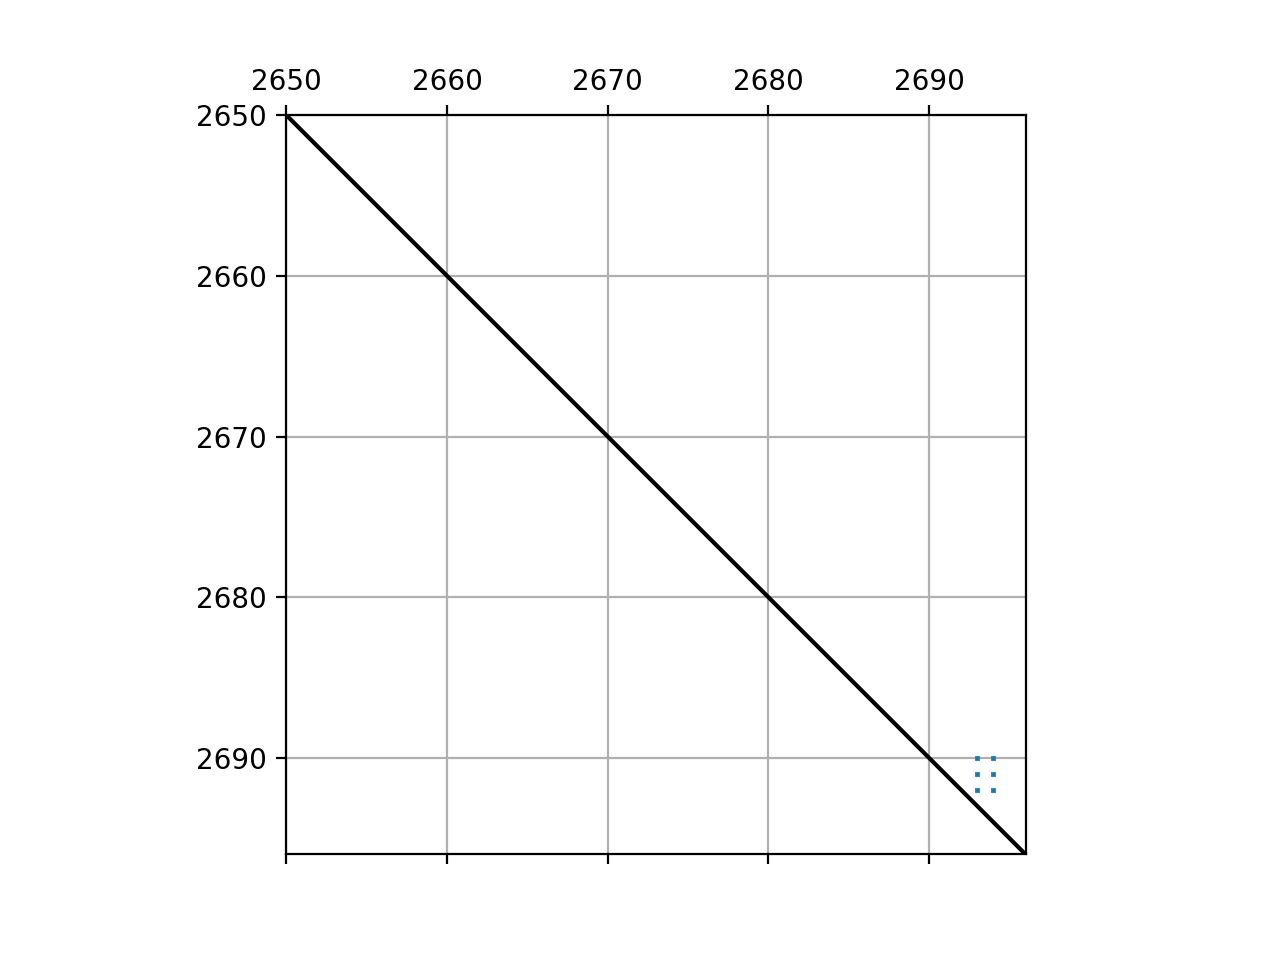

In [18]:
show_spy(B[-1], show_diagonal=True, grid=True, xlim=(2650, N_TARGET), ylim=(N_TARGET, 2650))

In [19]:
qdyn_model = LevelModel()

In [20]:
qdyn_model.add_ham(H[0], op_unit='au', op_type='pot')

In [21]:
for block in A:
    qdyn_model.add_ham(block, pulse=H[1][1], op_unit='au', op_type='dip')

In [22]:
for block in B:
    qdyn_model.add_ham(block, pulse=H[1][1], op_unit='au', op_type='dip')

In [23]:
for block in A:
    qdyn_model.add_ham(block.dag(), pulse=H[1][1], op_unit='au', op_type='dip', conjg_pulse=True)

In [24]:
for block in B:
    qdyn_model.add_ham(block.dag(), pulse=H[1][1], op_unit='au', op_type='dip', conjg_pulse=True)

In [25]:
qdyn_model.add_state(psi0, label='initial')

In [26]:
qdyn_model.add_state(psi_target, label='target')

In [27]:
qdyn_model.add_observable(
    qutip.ket2dm(psi0),
    'population.dat',
    exp_unit='iu',
    time_unit='ns',
    col_label='initial',
)
qdyn_model.add_observable(
    qutip.ket2dm(psi_target),
    'population.dat',
    exp_unit='iu',
    time_unit='ns',
    col_label='target',
)

In [28]:
qdyn_model.set_propagation(
    T=H[1][1].T,
    nt=len(H[1][1].states_tgrid),
    time_unit=H[1][1].time_unit,
)

In [29]:
RF = './rf_AB_blocks_prop'

In [30]:
qdyn_model.write_to_runfolder(RF)

In [31]:
%%bash -s "$RF"
qdyn_prop_traj --version
time qdyn_prop_traj --state-label=initial $1

QDYN 2.0dev revision 92024cace7e6b85565d01814a0de5f5cc9ae8167 (master)
  features: no-check-cheby, no-check-newton, no-parallel-ham, use-mkl=sequential, parallel-oct, backtraces, no-debug, no-no-ipo
  compiled with ifort on Sun Aug 18 18:25:27 2019 on host katamon
***** START OF PROGRAM qdyn_prop_traj ******
Tue Aug 20 21:28:54 +0200 2019

*** Read config file ./rf_AB_blocks_prop/config ***
*** Done reading config file ***
*** Initializing system ***
  *** Initializing grid ***
  No explicit grid found in config file! Initializing grid as one dimensional 1x1 fake grid
    Initializing grid as 1D cartesian grid without mapping
      Number of grid points was set to nr = 1 for dimension dim = 1! Initializing dimension 1 as a 1x1 fake-grid...
  *** Initializing pulses ***
    1 pulses in config file
    Initializing pulse 1
  *** Initializing dynamical generator ***
*** Done with initialization ***

Completed traj 1/1 in proc 1/1
Writing avg in proc 1/1

Tue Aug 20 21:33:45 +0200 2019
***

1

real	4m51.033s
user	4m50.813s
sys	0m0.220s


In [32]:
pop_data = np.genfromtxt((Path(RF) / 'population.dat')).transpose()

In [33]:
pop_data_baseline = np.genfromtxt('./rf_baseline/population.dat').transpose()

<IPython.core.display.Javascript object>


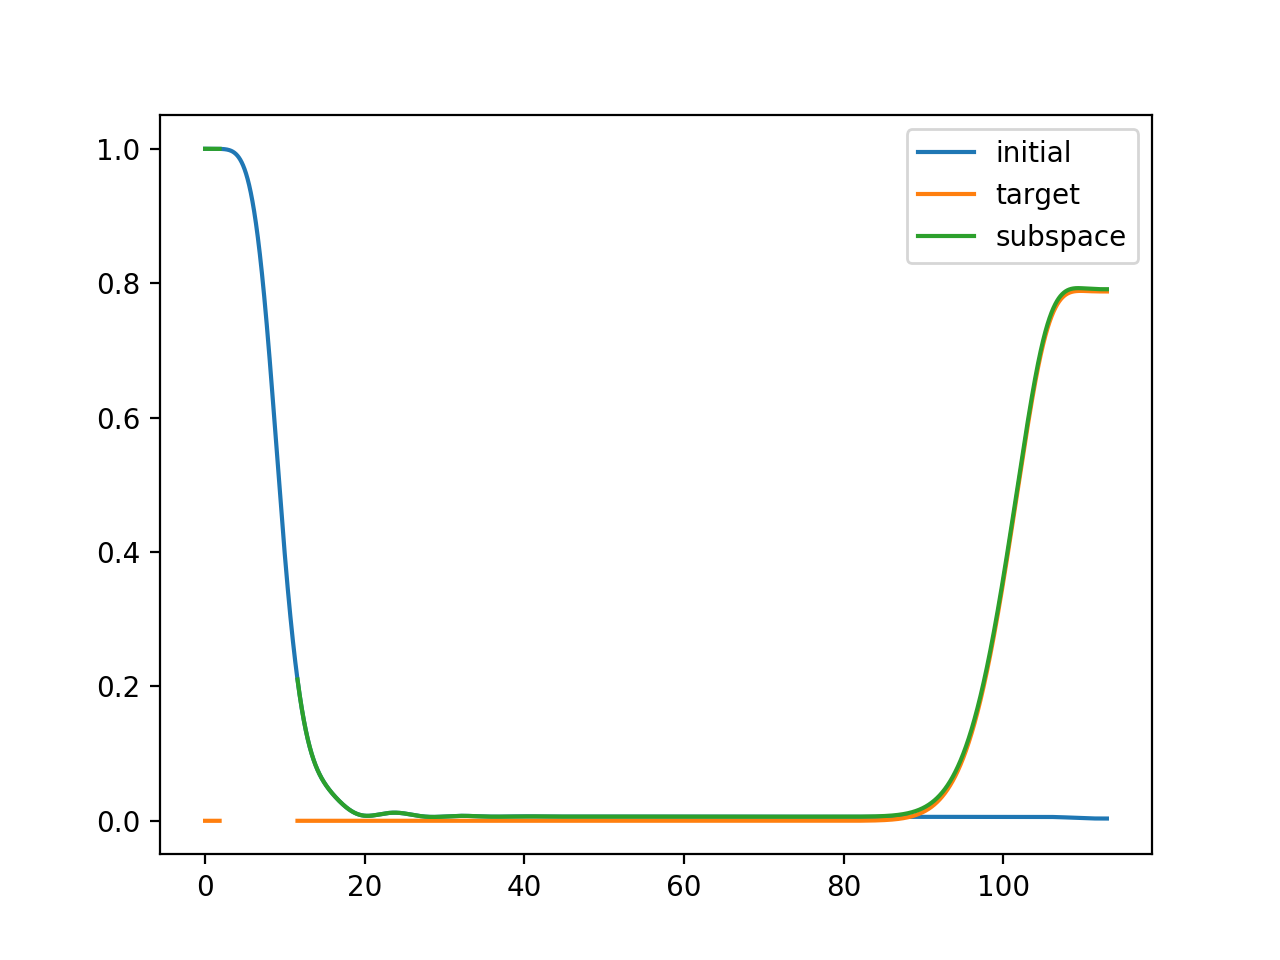

In [34]:
plot_population(pop_data)